In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv("call_center.csv")

In [3]:
df.head()

,timestamp,incoming_calls,handle_time,staffing_level,queue_length
0,473813,90.0,3.0,25.0,0.0
1,473461,79.0,3.0,44.0,0.0
2,475647,56.0,3.0,38.0,0.0
3,475941,55.0,3.0,20.0,0.0
4,473509,83.0,3.0,50.0,0.0


In [4]:
### AUTOGRADED TASK
def convert_to_datetime(column: pd.Series) -> pd.Series:
    """
    Convert the values of the given `column` from hours (`h`) since the epoch to `datetime64[ns]`.
    Return `column`.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    column = pd.to_datetime(column, unit="h")
    ### END SOLUTION

    return column

In [5]:
### TEST
def test_convert_to_datetime():
    column = pd.Series([450000, 460000, 470000, 480000])
    column = convert_to_datetime(column)
    assert column.dtype == "<M8[ns]", "Make sure that the `dtype` is `datetime64[ns]`."
    assert column[0] == pd.Timestamp("2021-05-03 00:00:00"), "Make sure that the `unit` is correct."
test_convert_to_datetime()
### BEGIN HIDDEN TESTS
def hidden_test_convert_to_datetime():
    column = pd.Series([451000, 461000, 471000, 481000])
    column = convert_to_datetime(column)
    assert column.dtype == "<M8[ns]", "Make sure that the `dtype` is `datetime64[ns]`."
    assert column[0] == pd.Timestamp("2021-06-13 16:00:00"), "Make sure that the `unit` is correct."
hidden_test_convert_to_datetime()
### END HIDDEN TESTS

In [6]:
df["timestamp"] = convert_to_datetime(df["timestamp"])

In [7]:
### AUTOGRADED TASK
def set_index_to_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    """
    Set the index of the given `df` to `timestamp`. Remove the `timestamp` column.
    Return `df`.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    df.set_index(keys=["timestamp"], drop=True, inplace=True)
    ### END SOLUTION

    return df

In [8]:
### TEST
def test_set_index_to_timestamp():
    df = pd.DataFrame(data={"timestamp": [450000, 460000, 470000], "value": [10, 20, 30]})
    df = set_index_to_timestamp(df)
    assert df.index[0] == 450000 and df.index[1] == 460000 and df.index[2] == 470000, "Make sure that the `index` is correctly set."
test_set_index_to_timestamp()
### BEGIN HIDDEN TESTS
def hidden_test_set_index_to_timestamp():
    df = pd.DataFrame(data={"timestamp": [490000, 480000, 470000], "value": [10, 20, 30]})
    df = set_index_to_timestamp(df)
    assert df.index[0] == 490000 and df.index[1] == 480000 and df.index[2] == 470000, "Make sure that the `index` is correctly set."
hidden_test_set_index_to_timestamp()
### END HIDDEN TESTS

In [9]:
df = set_index_to_timestamp(df)

In [10]:
### AUTOGRADED TASK
def sort_index(df: pd.DataFrame) -> pd.DataFrame:
    """
    Sort the index of the given `df`.
    Return `df`.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    df.sort_index(inplace=True)
    ### END SOLUTION

    return df

In [11]:
### TEST
def test_sort_index():
    df = pd.DataFrame(data=[[10, 20, 30]], index=[460000, 470000, 450000])
    df = sort_index(df.sample(frac=1., random_state=42))
    assert df.index[0] == 450000 and df.index[1] == 460000 and df.index[2] == 470000, "Make sure that the `index` is sorted."
test_sort_index()
### BEGIN HIDDEN TESTS
def hidden_test_sort_index():
    df = pd.DataFrame(data=[[10, 20, 30]], index=[470000, 480000, 460000])
    df = sort_index(df.sample(frac=1., random_state=42))
    assert df.index[0] == 460000 and df.index[1] == 470000 and df.index[2] == 480000, "Make sure that the `index` is sorted."
hidden_test_sort_index()
### END HIDDEN TESTS

In [12]:
df = sort_index(df)

In [13]:
features = ["handle_time", "staffing_level", "queue_length"]
target = "incoming_calls"

In [14]:
df.isnull().sum()

incoming_calls      0
handle_time       128
staffing_level    133
queue_length      142
dtype: int64

In [15]:
### AUTOGRADED TASK
def impute_missing_values(column: pd.Series) -> pd.Series:
    """
    Impute the missing values in the given `column` using linear interpolation.
    Return `column`.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    column = column.interpolate(method="linear")
    ### END SOLUTION

    return column

In [16]:
### TEST
def test_impute_missing_values():
    column = pd.Series([2, np.nan, 4])
    column = impute_missing_values(column)
    assert column[1] == 3., "Make sure you are using linear interpolation for data imputation."
test_impute_missing_values()
### BEGIN HIDDEN TESTS
def hidden_test_impute_missing_values():
    column = pd.Series([4, np.nan, 6])
    column = impute_missing_values(column)
    assert column[1] == 5., "Make sure you are using linear interpolation for data imputation."
hidden_test_impute_missing_values()
### END HIDDEN TESTS

In [17]:
for feature in features:
    df[feature] = impute_missing_values(df[feature])

In [18]:
df.isnull().sum()

incoming_calls    0
handle_time       0
staffing_level    0
queue_length      0
dtype: int64

In [19]:
num_lags = 7

In [20]:
### AUTOGRADED TASK
def create_lags(df: pd.DataFrame, features: list[str], target: str, num_lags: int) -> pd.DataFrame:
    """
    Generate lagged columns for each column (`features` and `target`), up to `num_lags`,
    within the given `df`.
    
    For each lag `k`, create new columns containing values
    shifted by `k` time steps into the past. Lagged columns are ordered
    chronologically from the most distant to the most recent lag, and the original
    column order is preserved within each lag.

    The name of the lagged columns follows the pattern `{column}_{lag}`.

    After creating the lagged columns, drop the original feature columns,
    keeping the original target column and the lagged columns.
    
    Finally, remove the rows with missing values.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    lags = range(num_lags, 0, -1)
    for lag in lags:
        for column in features + [target]:
            df[f"{column}_{lag}"] = df[column].shift(lag)
    df.drop(columns=features, inplace=True)
    df.dropna(inplace=True)
    ### END SOLUTION

    return df

In [21]:
### TEST
def test_create_lags():
    df = pd.DataFrame(data=[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 23]], columns=["A", "B", "C"])
    df = create_lags(df, ["A", "B", "C"], "A", 2)
    assert list(df.columns) == ["A_2", "B_2", "C_2", "A_1", "B_1", "C_1"] or list(df.columns[3:]) == ["A_2", "B_2", "C_2", "A_1", "B_1", "C_1"], "The order of the columns is not correct."
    assert all([not feature in list(df.columns) for feature in ["A", "B", "C"]]), "The features columns are not dropped."
    assert df.isnull().sum().sum().item() == 0, "The rows with missing values are not removed."
test_create_lags()

In [22]:
df = create_lags(df, features, target, num_lags)

In [23]:
X, y = df.drop(columns=target), df[[target]]

In [24]:
### AUTOGRADED TASK
def generate_train_val_test_split(X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Generate `train_X`, `val_X`, `test_X`, `train_y`, `val_y`, and `test_y` from the given `df`.
    The ratio of train, validation, and test is 70:15:15.
    First split `df` in train and test, then further split the test into test and validation.
    Set `random_state=42` to ensure reproducibility.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)
    test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5, shuffle=False, random_state=42)
    ### END SOLUTION

    return train_X, val_X, test_X, train_y, val_y, test_y

In [25]:
### TEST
def test_generate_train_val_test_split():
    df = pd.DataFrame([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
    X, y = df[[0]], df[[1]]
    train_X, val_X, test_X, train_y, val_y, test_y = generate_train_val_test_split(X, y)
    assert train_X.shape[0] == 3 and train_y.shape[0] == 3, "The shape of the train dataset is not correct."
    assert val_X.shape[0] == 1 and val_y.shape[0] == 1, "The shape of the validation dataset is not correct."
    assert test_X.shape[0] == 1 and test_y.shape[0] == 1, "The shape of the test dataset is not correct."
test_generate_train_val_test_split()

In [26]:
train_X, val_X, test_X, train_y, val_y, test_y = generate_train_val_test_split(X, y)

In [27]:
### AUTOGRADED TASK
def reshape_features(train_X: pd.DataFrame, val_X: pd.DataFrame, test_X: pd.DataFrame, num_lags: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reshape `train_X`, `val_X`, `test_X` into a shape of (num_samples, num_lags, num_features).
    Return `train_X`, `val_X`, and `test_X`.
    
    Note:
        Remove the `raise NotImplementedError()` line.
    """

    ### BEGIN SOLUTION
    train_X = train_X.reshape(train_X.shape[0], num_lags, (train_X.shape[1] // num_lags))
    val_X = val_X.reshape(val_X.shape[0], num_lags, (val_X.shape[1] // num_lags))
    test_X = test_X.reshape(test_X.shape[0], num_lags, (test_X.shape[1] // num_lags))
    ### END SOLUTION

    return train_X, val_X, test_X

In [28]:
### TEST
def test_reshape_features():
    train_X = np.array([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18], [19, 20, 21, 22, 23, 24]])
    val_X = np.array([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12]])
    test_X = np.array([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12]])
    train_X, val_X, test_X = reshape_features(train_X, val_X, test_X, 2)
    assert train_X.shape[0] == 4 and train_X.shape[1] == 2 and train_X.shape[2] == 3, "The shape of the train dataset is not correct."
    assert val_X.shape[0] == 2 and val_X.shape[1] == 2 and val_X.shape[2] == 3, "The shape of the validation dataset is not correct."
    assert test_X.shape[0] == 2 and test_X.shape[1] == 2 and test_X.shape[2] == 3, "The shape of the test dataset is not correct."
test_reshape_features()

In [29]:
train_X, val_X, test_X = reshape_features(train_X.to_numpy(), val_X.to_numpy(), test_X.to_numpy(), num_lags)

In [30]:
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float32)

val_X = torch.tensor(val_X, dtype=torch.float32)
val_y = torch.tensor(val_y.to_numpy(), dtype=torch.float32)

test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float32)

In [31]:
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

In [32]:
### AUTOGRADED TASK
def create_data_loader(dataset: TensorDataset) -> DataLoader:
    """
    Create a data loader for the given dataset with a batch size of 64.
    Return `data_loader`.

    Note:
        Remove the `raise NotImplementedError()` line.
    """
    ### BEGIN SOLUTION
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)
    ### END SOLUTION

    return data_loader

In [33]:
### TEST
def test_create_data_loader():
    X = torch.randn(100, 10)
    y = torch.randint(0, 2, (100,))
    dataset = TensorDataset(X, y)
    data_loader = create_data_loader(dataset)
    assert data_loader.batch_size == 64 and isinstance(data_loader.sampler, torch.utils.data.SequentialSampler), "The data loader is not configured properly."
test_create_data_loader()

In [34]:
train_loader = create_data_loader(train_dataset)
val_loader = create_data_loader(val_dataset)
test_loader = create_data_loader(test_dataset)

In [35]:
class CNNRegressor(nn.Module):
    """
    A class for a CNN-based regression model.

    The model consists of an `torch.nn.Sequential` module with:
        - an 1D convolutional layer with 64 filters, a kernel of size 4, and ReLU activation function;
        - an 1D convolutional layer with 32 filters, a kernel of size 4, and ReLU activation function;
        - a flattening layer;
        - a fully connected layer with 32 neurons and ReLU activation function; and
        - a fully connected layer with 1 neuron and linear activation function.
        
    Note:
        Store the `torch.nn.Sequential` module in an attribute named `net`.
        Remove the `raise NotImplementedError()` line.
    """
    def __init__(self, num_features):
        super().__init__()
        ### Hint: self.net = nn.Sequential()
        ### BEGIN SOLUTION
        self.net = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=4),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        ### END SOLUTION

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        return self.net(x)

In [36]:
### TEST
def test_create_cnn_regressor_1():
    model = CNNRegressor(num_features=2)
    assert hasattr(model, "net")
    assert isinstance(model.net[0], nn.Conv1d)
    assert hasattr(model.net[0], "in_channels") and model.net[0].in_channels == 2
    assert hasattr(model.net[0], "out_channels") and model.net[0].out_channels == 64
    assert hasattr(model.net[0], "kernel_size") and model.net[0].kernel_size[0] == 4
    assert isinstance(model.net[1], nn.ReLU)
test_create_cnn_regressor_1()

In [37]:
### TEST
def test_create_cnn_regressor_2():
    model = CNNRegressor(num_features=2)
    assert hasattr(model, "net")
    assert isinstance(model.net[2], nn.Conv1d)
    assert hasattr(model.net[2], "in_channels") and model.net[2].in_channels == 64
    assert hasattr(model.net[2], "out_channels") and model.net[2].out_channels == 32
    assert hasattr(model.net[2], "kernel_size") and model.net[2].kernel_size[0] == 4
    assert isinstance(model.net[3], nn.ReLU)
test_create_cnn_regressor_2()

In [38]:
### TEST
def test_create_cnn_regressor_3():
    model = CNNRegressor(num_features=2)
    assert hasattr(model, "net")
    assert isinstance(model.net[4], nn.Flatten)
test_create_cnn_regressor_3()

In [39]:
### TEST
def test_create_cnn_regressor_4():
    model = CNNRegressor(num_features=2)
    assert hasattr(model, "net")
    assert isinstance(model.net[5], nn.Linear)
    assert hasattr(model.net[5], "in_features") and model.net[5].in_features == 32
    assert hasattr(model.net[5], "out_features") and model.net[5].out_features == 32
    assert isinstance(model.net[6], nn.ReLU)
test_create_cnn_regressor_4()

In [40]:
### TEST
def test_create_cnn_regressor_5():
    model = CNNRegressor(num_features=2)
    assert hasattr(model, "net")
    assert isinstance(model.net[7], nn.Linear)
    assert hasattr(model.net[7], "in_features") and model.net[7].in_features == 32
    assert hasattr(model.net[7], "out_features") and model.net[7].out_features == 1
test_create_cnn_regressor_5()

In [41]:
num_features = 4
model = CNNRegressor(num_features)

In [42]:
### AUTOGRADED TASK
def define_loss_fn_and_optimizer():
    """
    Define an appropriate loss_fn and an Adam optimizer with a learning rate of 0.005.
    Return `loss_fn` and `optimizer`.

    Note:
        Remove the `raise NotImplementedError()` line.
    """
    ### BEGIN SOLUTION
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-3)
    ### END SOLUTION

    return loss_fn, optimizer

In [43]:
### TEST
def test_define_loss_fn_and_optimizer():
    true_y = torch.tensor([1, 2, 3], dtype=torch.float32)
    pred_y = torch.tensor([1, 4, 3], dtype=torch.float32)
    loss_fn, optimizer = define_loss_fn_and_optimizer()
    assert round(loss_fn(true_y, pred_y).item(), 2) == 1.33
    assert optimizer.param_groups[0]["lr"] == 5e-3
test_define_loss_fn_and_optimizer()

In [44]:
loss_fn, optimizer = define_loss_fn_and_optimizer()

In [45]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()

    total_loss = 0
    for features, targets in dataloader:
        features, targets = features, targets

        optimizer.zero_grad()

        outputs = model(features)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [46]:
def evaluate(model, dataloader, loss_fn):
    model.eval()

    total_loss, predictions = 0, []
    with torch.no_grad():
        for features, targets in dataloader:
            features, targets = features, targets

            outputs = model(features)
            loss = loss_fn(outputs, targets)

            predictions.extend(outputs.tolist())
            
            total_loss += loss.item()

    return total_loss / len(dataloader), predictions

In [47]:
num_epochs = 8

In [48]:
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs):
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, loss_fn, optimizer)
        train_losses.append(train_loss)
        val_loss, pred_y = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)

        mape = mean_absolute_percentage_error(val_y.tolist(), pred_y)

        print(f"Epoch {epoch:3d}/{num_epochs} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} mape={mape:.4f}")
    
    return train_losses, val_losses

In [49]:
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)

Epoch   1/8 | train_loss=580.0345 val_loss=108.0710 mape=0.1352
Epoch   2/8 | train_loss=65.9269 val_loss=57.8513 mape=0.0942
Epoch   3/8 | train_loss=54.2629 val_loss=55.4415 mape=0.0904
Epoch   4/8 | train_loss=48.8500 val_loss=49.2441 mape=0.0849
Epoch   5/8 | train_loss=45.1645 val_loss=46.5404 mape=0.0822
Epoch   6/8 | train_loss=42.8123 val_loss=44.8128 mape=0.0806
Epoch   7/8 | train_loss=41.2355 val_loss=43.9996 mape=0.0797
Epoch   8/8 | train_loss=40.3016 val_loss=43.4455 mape=0.0792


<Axes: >

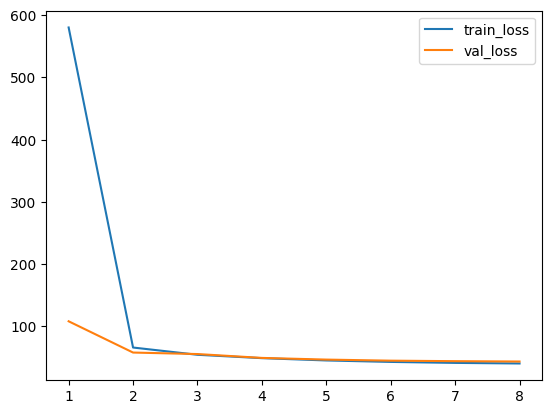

In [50]:
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label="train_loss")
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label="val_loss")

In [51]:
test_loss, pred_y = evaluate(model, test_loader, loss_fn)

In [52]:
print(f"MAE: {mean_absolute_error(test_y, pred_y)}")
print(f"MAPE: {mean_absolute_percentage_error(test_y, pred_y)}")
print(f"MSE: {mean_squared_error(test_y, pred_y)}")
print(f"RMSE: {root_mean_squared_error(test_y, pred_y)}")
print(f"R2 Score: {r2_score(test_y, pred_y)}")

MAE: 4.790250132588736
MAPE: 0.07208452367846242
MSE: 35.58673392250099
RMSE: 5.965461752664331
R2 Score: 0.8655895543093921


In [53]:
### TEST
assert r2_score(test_y, pred_y) > 0.70